El algoritmo del algoritmo es optimizar por métodos de montecarlos, es decir tirar N partículas a la muestra y de manera inteligente seleccionar las M partículas cuya posición evaluada en la función a optimizar sea el menor y volver a muestrear N partículas, se opta de esta manera para disminuir el número de veces que toca llamar a la función a optimizar. Luego de esto se repite el proceso tal como el algoritmo posterior.


# Algoritmo Base

- Despliegan N partículas en todo el muestreo
- Se escogen las M partículas con el mejor resultado
- Se ubica una nueva zona alrededor de la partícula con un valor V, ya sea una zona N-cúbica  
- Se repite el lo anterior en al nueva zona

# Se requiere:

- Iniciar una clase de partícula con la posición, zona y valor de su función a
optimizar.

- una representación de cada partícula de este tipo

      def __repr__(self):
        pos_str = ", ".join(f"{p:.2f}" for p in self.pos)
        return f"Posición=[{pos_str}], Zona={self.zone:.2f}, Valor={self.value:.  3f}"

- Cada ciclo borra las partículas de la anterior zona, el algoritmo solo recuerda las partículas de las zonas M zonas actuales.

- EL usuario escoge el número de ciclos, el número de datos a muestrear, y que tipo de distribución son las partículas generadas dentro de los ciclos, en el primer ciclo el muestreo es siempre normal.


- AL final del número de ciclos seleccionados, escoge la partícula con el menor valor de todas las partículas, tiempo que duró la ejecución, el error reportado como la desviación cuadrática de todas las partículas que están en la misma zona que la partícula con el mejor resultado.










# [Funciones de prueba](http://www-optima.amp.i.kyoto-u.ac.jp/member/student/hedar/Hedar_files/TestGO_files/Page295.htm)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
# Función objetivo a optimizar (ejemplo: función esfera, cuyo mínimo es en 0)
def esfera(pos):
    return np.sum(np.array(pos)**2)

# Función Rosenbrock, minimo global (1,1,1,...,1)
def rosenbrock(pos):
    return np.sum([100.0*(pos[i+1] - pos[i]**2)**2 + (pos[i]-1)**2 for i in range(len(pos)-1)])

# Función Rastringin, minimo global (0,0,0,...,0)
def rastringin(pos):
    return np.sum([pos[i]**2 - 10*np.cos(2*np.pi*pos[i]) + 10 for i in range(len(pos))])

# Función Schwefel, minimo global (420.9687)
def schwefel(pos):
    return 418.9829*len(pos) - np.sum([pos[i]*np.sin(np.sqrt(np.abs(pos[i]))) for i in range(len(pos))])

# Función Griewank, Minimo global (0,0,0,...,0)
def griewank(pos):
    return np.sum([pos[i]**2/4000 for i in range(len(pos))]) - np.prod([np.cos(pos[i]/np.sqrt(i+1)) for i in range(len(pos))] ) + 1

# Función Ackley
def ackley(pos):
    return -20 * np.exp(-0.2 * np.sqrt(0.5 * np.sum(np.array(pos)**2))) - np.exp(0.5 * (np.cos(2 * np.pi * np.array(pos)).sum()))


In [ ]:
import time
import random

# Clase Particle que almacena la posición, el tamaño de la zona y el valor de la función
class Particle:
    def __init__(self, pos, value, zone_id):
        self.pos = np.array(pos)
        self.value = value
        self.zone_id = zone_id  # Identificador único de la zona de la partícula

    def __repr__(self):

        pos_str = ", ".join(f"{p:.2e}" for p in self.pos)
        return f"Posición=[{pos_str}], Zona={self.zone_id:.2f}, Valor={self.value:.5f}"

def metodo_busqueda_aleatorio(cycles,N,M,distrib,rang,zone_size,objective_function,x_0):


    dim = len(rang)

    if np.array(x_0).any() == np.array([0]*dim).any():
      rangite = np.array(rang) * (1-zone_size)


    else:

      low = np.array(x_0) + np.abs(np.array(rang)[:,0])
      high = np.array(x_0) - np.abs(np.array(rang)[:,1])
      rang = np.array([ [low[i],high[i]] for i in range(len(low))] )
      rangite = rang * (1-zone_size)


    # Iniciar medición de tiempo
    start_time = time.time()

    # --------------------
    # Ciclo 0: muestreo en todo el espacio
    # --------------------
    particles = []
    for i in range(N):
        pos = [np.random.uniform(low=rang[j][0], high=rang[j][1]) for j in range(dim)]
        value = objective_function(pos)
        # En el ciclo 0 asignamos zone_id = 0 a todas las partículas
        p = Particle(pos, value=value, zone_id=0)
        particles.append(p)

    # Se seleccionan las M partículas con menor valor
    particles.sort(key=lambda p: p.value)
    best_particles = particles[:M]

    # Se utilizará para almacenar las partículas de la última ronda (por zona)
    final_zone_particles = {}
    # Variable para asignar IDs únicos a cada nueva zona
    global_zone_id = 0

    #Ite_best_particles = [particles[:1]]

    # --------------------
    # Ciclos posteriores: cada uno se muestrea en la zona de cada partícula "madre"
    # --------------------
    for cycle in range(1, cycles):
        new_best_particles = []
        zone_particles = {}  # Diccionario para almacenar todas las partículas muestreadas por zona en este ciclo
        for parent in best_particles:
            # Asignar un nuevo id de zona para la región de la partícula "madre"
            current_zone_id = global_zone_id
            global_zone_id += 1
            # Muestrear N partículas en un hiper-cubo centrado en parent.pos
            if distrib == "normal":
                # Distribución normal con media en parent.pos y desviación = zone_size
                lk = np.sum(np.abs(rangite),axis = 1)
                samples = [[np.random.normal(loc= parent.pos[i], scale=lk[i]) for i in range(dim)]for j in range(N)]

            elif distrib in ["uniforme", "uniform"]:
                #Distribución uniforme en un cubo: cada componente se toma entre parent.pos - zone_size y parent.pos + zone_size
                low = np.array(parent.pos) + np.abs(np.array(rangite[:,0]))
                high = np.array(parent.pos) - np.abs(np.array(rangite[:,1]))
                samples = [[np.random.uniform(low=low[i], high=high[i]) for i in range(dim)]for j in range(N)]

            else: # De forma predeterminada se usa de usa la distribución uniforme para el mapeo
                print("Tipo de distribución no reconocido. Se usará uniforme por defecto.")
                low = np.array(parent.pos) + np.abs(np.array(rangite[:,0]))
                high = np.array(parent.pos) - np.abs(np.array(rangite[:,1]))
                samples = [[np.random.uniform(low=low[i], high=high[i]) for i in range(dim)]for j in range(N)]

            current_zone_particles = []

            for s in samples:
                val = objective_function(s)
                particle = Particle(s, value=val, zone_id=current_zone_id)
                current_zone_particles.append(particle)

            # Guardar todas las partículas de esta zona
            zone_particles[current_zone_id] = current_zone_particles
            # Seleccionar la mejor partícula de esta zona (la de menor valor)
            best_in_zone = min(current_zone_particles, key=lambda p: p.value)
            new_best_particles.append(best_in_zone)

        #Actualiza el tamaño de la zona
        rangite *= (1-zone_size)


        # Actualizar las mejores partículas para el siguiente ciclo
        new_best_particles.sort(key=lambda p: p.value)
        #Ite_best_particles.append(new_best_particles[:1]) #lo uso para saber resultados iteración a iteración
        best_particles = new_best_particles[:M]
        # Al final de este ciclo se actualiza el conjunto final de partículas por zona
        final_zone_particles = zone_particles

    # --------------------
    # Resultado final: se escoge la mejor partícula de las M zonas actuales
    # --------------------
    overall_best = min(best_particles, key=lambda p: p.value)

    # Se obtienen todas las partículas que pertenecen a la misma zona que la partícula óptima
    zone_id_best = overall_best.zone_id
    particles_in_best_zone = final_zone_particles.get(zone_id_best, [overall_best])

    # Calcular el error como la desviación cuadrática (root mean square deviation)
    values = np.array([p.value for p in particles_in_best_zone])
    if len(values) > 1:
        error = np.sqrt(np.mean((values - overall_best.value) ** 2))
    else:
        error = 0.0

    elapsed_time = time.time() - start_time

    # Mostrar resultados finales
    #print("\nResultado final:")
    #print("Mejor partícula encontrada:", overall_best)
    #print(f"Tiempo de ejecución: {elapsed_time:.4f} segundos")
    #print(f"Error (desviación cuadrática en la zona): {error:.6f}")
    #return Ite_best_particles, overall_best

    return overall_best

In [ ]:
class TunnelingOptimizer:
    def __init__(self, func, bounds, max_cycles=50, eta=2.0, tol=1e-6):
        """
        :param func: Función objetivo a minimizar (f(x)).
        :param bounds: Límites del espacio de búsqueda (ej. [(-5.12, 5.12), ...]).
        :param max_cycles: Número máximo de ciclos (minimización + tunneling).
        :param eta: Factor de penalización para los polos en T(x).
        :param tol: Tolerancia para considerar convergencia.
        """
        self.func = func
        self.bounds = bounds
        self.max_cycles = max_cycles
        self.eta = eta
        self.tol = tol
        self.minima = []  # Almacena los mínimos encontrados
        self.f_values = []  # Valores de f en los mínimos

    def tunneling_function(self, x):
        """Función de tunneling T(x)."""
        f_current = self.f_values[-1]
        numerator = self.func(x) - f_current

        # Penalización por cercanía a mínimos previos (denominador)
        denominator = 1.0
        for x_min in self.minima:
            distance = np.linalg.norm(x - x_min)
            denominator *= (distance**2 + 1e-6)  # +epsilon para evitar división por cero

        return numerator / (denominator ** self.eta)

    def minimize_phase(self, x0):
        """Fase de minimización local usando MBA"""
        res = metodo_busqueda_aleatorio(10,10, 2, "uniforme",self.bounds, 0.35, self.func,x0)
        return res.pos, res.value

    def tunneling_phase(self, x_last):
        """Fase de tunneling: busca x tal que T(x) <= 0."""
        # Estrategia: muestreo aleatorio + optimización local
        best_x = None
        best_T = np.inf

        # Muestreo aleatorio en el espacio de búsqueda
        for _ in range(10):
            x_candidate,fvalcanditate = self.minimize_phase(x0= 0)
            T_val = self.tunneling_function(x_candidate)

            if T_val <= 0:
                return x_candidate  # Punto válido encontrado

            if T_val < best_T:
                best_T = T_val
                best_x = x_candidate

        # Si no se encontró, optimizar T(x) localmente desde el mejor candidato
        res = metodo_busqueda_aleatorio(10,10, 2, "uniforme",self.bounds, 0.35, self.tunneling_function,best_x)
        return res.pos if res.value <= 0 else None

    def optimize(self, x0):
        """Ejecuta el algoritmo de tunneling."""
        x_current = x0

        for cycle in range(self.max_cycles):

            #print(cycle)
            # Fase de minimización
            x_min, f_min = self.minimize_phase(x_current)

            # Guardar el mínimo encontrado
            if not self.minima or f_min < self.f_values[-1] - self.tol:
                self.minima.append(x_min)
                self.f_values.append(f_min)

            # Fase de tunneling
            x_tunnel = self.tunneling_phase(x_min)

            if x_tunnel is None:
                #el problema es aqui
                break  # No se encontró mejor punto

            x_current = x_tunnel

        # Encontrar el mínimo global
        idx_global = np.argmin(self.f_values)
        return self.minima[idx_global], self.minima, cycle

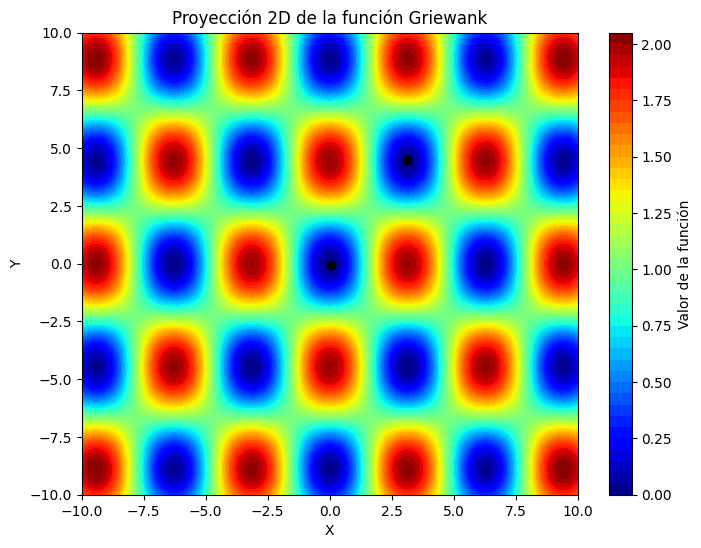

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

bounds = [(-10, 10)]*2
x0 = [0]*2  # Punto inicial

# Ejecutar optimización
optimizer = TunnelingOptimizer(griewank, bounds, max_cycles=100, eta=2.0)
x_opt, x_minimo, cycle = optimizer.optimize(x0)

# Definir la función de Griewank
def Griewank(x, y):
    term1 = (x**2 + y**2) / 4000
    term2 = np.cos(x / np.sqrt(1)) * np.cos(y / np.sqrt(2))
    return term1 - term2 + 1

# Crear una malla de puntos en el rango [-5.12, 5.12]
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(x, y)
Z = Griewank(X, Y)

# Graficar el mapa de calor
plt.figure(figsize=(8, 6))
plt.plot([x_minimo[i][0] for i in range(len(x_minimo))], [x_minimo[i][1] for i in range(len(x_minimo))], "ko")
plt.contourf(X, Y, Z, levels=50, cmap='jet')
plt.colorbar(label='Valor de la función')
plt.title('Proyección 2D de la función Griewank')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [ ]:
]


In [ ]:
import numpy as np


etalis  = np.linspace(1,10,100)

bounds = [(-5.12, 5.12)]*3

x_glo = np.zeros(100)
cycles = np.zeros(100)

for i in range(len(etalis)):
  optimizer = TunnelingOptimizer(griewank, bounds, max_cycles=100, eta=etalis[i])
  xx_glo, xx_liss, xcycle = optimizer.optimize(x0)
  x_glo[i] = np.sqrt(np.sum((xx_glo**2)))
  cycles[i] = xcycle

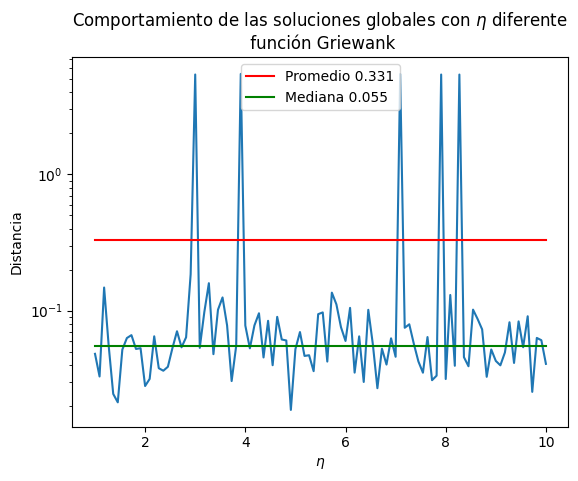

In [ ]:


pro = np.mean(x_glo)
mediana = np.median(x_glo)

plt.semilogy(etalis,x_glo)
plt.plot(etalis,np.ones(100)*pro, "r-", label= f"Promedio {pro:.3f}")
plt.plot(etalis,np.ones(100)*mediana, "g-", label= f"Mediana {mediana:.3f}")
plt.legend()
plt.xlabel("$\eta$")
plt.ylabel("Distancia")
plt.title(f"Comportamiento de las soluciones globales con $\eta$ diferente \n función Griewank");

In [ ]:
moda[0]

np.float64(0.01865996410868517)

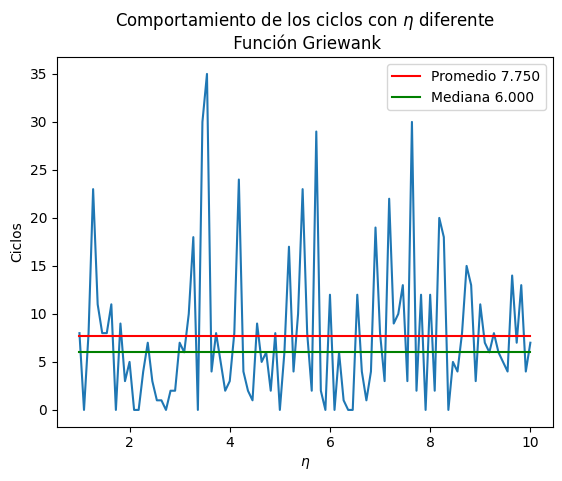

In [ ]:
pro_cycles = np.mean(cycles)
medi_cirs = np.median(cycles)

plt.plot(etalis,cycles)
plt.plot(etalis,np.ones(100)*pro_cycles, "r-", label= f"Promedio {pro_cycles:.3f}")
plt.plot(etalis,np.ones(100)*medi_cirs, "g-", label= f"Mediana {medi_cirs:.3f}")
plt.legend()
plt.xlabel("$\eta$")
plt.ylabel("Ciclos")
plt.title(f"Comportamiento de los ciclos con $\eta$ diferente \n Función Griewank");

In [ ]:
rang = [[-60,60]]*3

In [ ]:
frang = np.linspace(0,1,100)
min_dis = np.zeros(100)
min_frang = np.zeros(100)

for j in range(100):
  data = [metodo_busqueda_aleatorio(20,10,2,"uniforme",rang, frang[i], ackley, 0) for i in range(len(frang))]
  dis = [ np.sqrt(np.sum((data[i].pos - 0)**2)) for i in range(len(data))]
  dis = np.array(dis) # Convert the list 'dis' to a NumPy array
  min_index = np.argmin(dis)  # Find the index of the minimum value
  min_dis[j] = dis[min_index]  # Get the minimum value using the index
  min_frang[j] = frang[min_index]  # Get the corresponding frang value

pro_min_dis = np.mean(min_dis)
pro_min_frang = np.mean(min_frang)
des_min_dis = np.std(min_dis)
des_min_frang = np.std(min_frang)

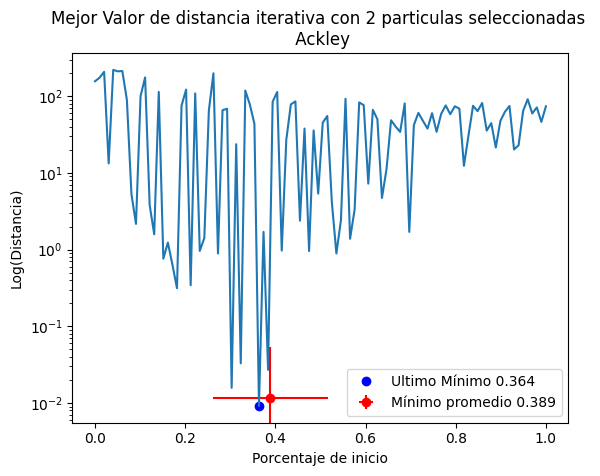

In [ ]:
# Assuming 'dis' is your list

plt.errorbar(pro_min_frang, pro_min_dis, xerr = 2*des_min_frang, yerr = 2*des_min_dis, fmt = "o", color= "red",label= f"Mínimo promedio {pro_min_frang:.3f}")
plt.semilogy(min_frang[-1], min_dis[-1], "bo", label= f"Ultimo Mínimo {min_frang[-1]:.3f}")
plt.legend()
plt.ylabel("Log(Distancia)")
plt.xlabel("Porcentaje de inicio")
plt.title(f"Mejor Valor de distancia iterativa con 2 particulas seleccionadas \n Ackley")
plt.plot(frang,dis);

In [ ]:
def graficador(fun, txt, x0):
  rang = [[-33,33]]*3
  dat3, bestpart = metodo_busqueda_aleatorio(100,10,2,"uniforme",rang, 0.35, fun, x_0 = 0)
  disdata = [np.sqrt(np.sum((dat3[i][0].pos - x0)**2)) for i in range(len(dat3))]
  bestdis = np.sqrt(np.sum((bestpart.pos - x0)**2 ))
  ite = np.linspace(1,100,100)
  plt.semilogy(ite,disdata)
  plt.plot(ite,np.ones(100)*bestdis, "r-" ,label = f"Mejor resultado {bestpart.pos}")
  plt.title(f"Evolución del algoritmo para la función {txt}")
  plt.legend()
  plt.ylabel("Distancia")
  plt.xlabel("Iteración");

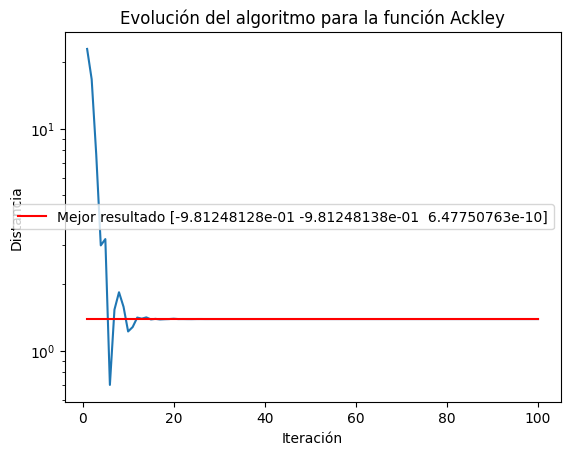

In [ ]:
graficador(ackley, "Ackley", 0)


Resultado final:
Mejor partícula encontrada: Posición=[-2.29e-02, 9.89e-01, -1.76e-03], Zona=240.00, Valor=-21.84142
Tiempo de ejecución: 0.1276 segundos
Error (desviación cuadrática en la zona): 0.000000
